<a href="https://colab.research.google.com/github/Vaycold/tensorflow_tutorial/blob/main/%2316.%EB%A7%9E%EC%B6%A4%ED%95%99%EC%8A%B5%20%EB%91%98%EB%9F%AC%EB%B3%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 붗꽃 분류문제

In [1]:
# 데이터셋 다운로드
import os
import tensorflow as tf
import matplotlib.pyplot as plt

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))

16384/2194 [================================================================================================================================================================================================================================] - 0s 0us/step
데이터셋이 복사된 위치: /root/.keras/datasets/iris_training.csv


In [2]:
!head -n5 {train_dataset_fp}
'''
첫 번째 줄  = 헤더(정보를 가지고 있음) ; 120개 sample, 각 sample's feautre : 4, # of labels : 3
'''
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]
print('\n')
print('Feature : ', feature_names)
print()
print('Labels : ', label_name)

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


Feature :  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Labels :  species


In [3]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [4]:
# tf.data.Dataset 생성
'''
텐서플로의 데이터셋 api는 데이터를 적재할 때 발생하는 다양한 경우를 다룰 수 있음.
훈련에 필요한 형태로 데이터를 읽고 변환하는 API

데이터셋이 CSV파일이므로 적절한 형태로 데이터를 구분하기 위해 make_csv_dataset 함수를 사용
 -> 훈련모델을 위한 데이터를 생성하므로, 초기값은(shuffle = True, shuffle_buffer_size = 10000)과
 무한반복(num_epochs= None)으로 설정되어 있음.
'''
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp, # csv 파일 인듯?
    batch_size = batch_size,
    column_names = column_names,
    label_name = label_name,
    num_epochs = 1
)

In [5]:
# make_csv_dataset 함수 : (features,label) 쌍으로 구성된 tf.data.Dataset을 반환
# features -> 딕셔너리 객체인 {'feature_name' : value} 로 주어짐

feature, labels = next(iter(train_dataset))
print(feature)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.5, 4.7, 5.7, 7. , 6.7, 7.2, 6.8, 5.8, 5.1, 6.4, 4.8, 6.8, 5.9,
       5.6, 5.1, 5.1, 7.6, 6.6, 5.6, 4.5, 6.7, 6.6, 6.3, 5.8, 4.6, 5.4,
       4.9, 6.5, 6.3, 6.5, 6. , 4.9], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3. , 3.2, 4.4, 3.2, 3. , 3.2, 3.2, 2.7, 2.5, 3.1, 3.1, 3. , 3.2,
       2.7, 3.8, 3.7, 3. , 2.9, 2.9, 2.3, 3.1, 3. , 2.7, 2.7, 3.4, 3.9,
       2.4, 3. , 3.3, 3.2, 2.9, 3.1], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5.2, 1.3, 1.5, 4.7, 5.2, 6. , 5.9, 5.1, 3. , 5.5, 1.6, 5.5, 4.8,
       4.2, 1.5, 1.5, 6.6, 4.6, 3.6, 1.3, 5.6, 4.4, 4.9, 5.1, 1.4, 1.3,
       3.3, 5.8, 6. , 5.1, 4.5, 1.5], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2. , 0.2, 0.4, 1.4, 2.3, 1.8, 2.3, 1.9, 1.1, 1.8, 0.2, 2.1, 1.8,
       1.3, 0.3, 0.4, 2.1, 1.3, 1.3, 0.3, 2.4, 1.4, 1.8, 1.9,

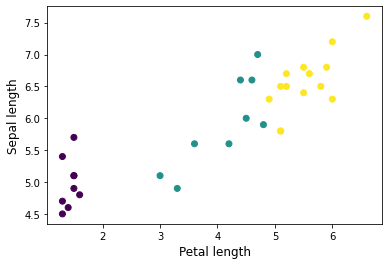

In [6]:
plt.scatter(
    feature['petal_length'],
    feature['sepal_length'],
    c = labels,
    cmap = 'viridis'
)

plt.xlabel('Petal length', size = 12)
plt.ylabel('Sepal length', size = 12)
plt.show()

In [7]:
# 모델 구축 단계를 단순화 하기 위해 특성 딕셔너리를 (batch_size, num_features) 의 형태를 가지는
# 단일 배열로 구성하는 함수 생성

def pack_features_vector(features, labels) :
    '''특성들을 단일 배열로 묶자.'''
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [8]:
# 그 후 각 (features, labels) 쌍의 특성을 훈련 데이터 세트에 쌓기 위해 tf.data.Dataset.map 사용
train_dataset = train_dataset.map(pack_features_vector)

In [9]:
# 데이터셋의 특성요소는 이제 형태가 (batch_size, num_features)인 배열
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[7.3 2.9 6.3 1.8]
 [5.  3.2 1.2 0.2]
 [5.  2.3 3.3 1. ]
 [7.9 3.8 6.4 2. ]
 [5.4 3.7 1.5 0.2]], shape=(5, 4), dtype=float32)


In [20]:
# keras를 사용한 모델 생성
model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)),
            tf.keras.layers.Dense(10, activation = tf.nn.relu),
            tf.keras.layers.Dense(3)
])

In [21]:
features

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[7.3, 2.9, 6.3, 1.8],
       [5. , 3.2, 1.2, 0.2],
       [5. , 2.3, 3.3, 1. ],
       [7.9, 3.8, 6.4, 2. ],
       [5.4, 3.7, 1.5, 0.2],
       [6.1, 2.6, 5.6, 1.4],
       [5. , 3.4, 1.6, 0.4],
       [6.4, 2.8, 5.6, 2.2],
       [5.6, 2.7, 4.2, 1.3],
       [4.9, 3.1, 1.5, 0.1],
       [4.4, 2.9, 1.4, 0.2],
       [7.2, 3.2, 6. , 1.8],
       [6.7, 3. , 5.2, 2.3],
       [4.7, 3.2, 1.6, 0.2],
       [6.8, 3. , 5.5, 2.1],
       [6.7, 3.1, 5.6, 2.4],
       [5. , 3.4, 1.5, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [5.2, 2.7, 3.9, 1.4],
       [6.2, 2.8, 4.8, 1.8],
       [4.9, 3. , 1.4, 0.2],
       [6.5, 3.2, 5.1, 2. ],
       [6.3, 3.3, 6. , 2.5],
       [5.5, 3.5, 1.3, 0.2],
       [4.6, 3.2, 1.4, 0.2],
       [5.1, 2.5, 3. , 1.1],
       [6.5, 3. , 5.8, 2.2],
       [6.4, 3.2, 4.5, 1.5],
       [6.3, 2.5, 5. , 1.9],
       [7.2, 3.6, 6.1, 2.5],
       [6.3, 2.3, 4.4, 1.3],
       [6.5, 3. , 5.2, 2. ]], dtype=float32)>

In [22]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.7742563 ,  3.6208503 ,  1.0501107 ],
       [ 0.7213524 ,  1.743093  ,  1.3307035 ],
       [-0.12197559,  2.4480412 ,  1.0112993 ],
       [-0.6991399 ,  4.0784826 ,  1.3123649 ],
       [ 0.71534014,  1.9321897 ,  1.4117126 ]], dtype=float32)>

In [23]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.01133117, 0.91842836, 0.07024044],
       [0.17802261, 0.49455148, 0.3274259 ],
       [0.05823483, 0.7608988 , 0.18086636],
       [0.0078557 , 0.93342644, 0.0587179 ],
       [0.15666628, 0.5289889 , 0.31434476]], dtype=float32)>

In [24]:
print(' 예측 : {}'.format(tf.argmax(predictions, axis=1)))
print(' 레이블 :{}'.format(labels))

 예측 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 레이블 :[2 0 1 2 0 2 0 2 1 0 0 2 2 0 2 2 0 2 1 2 0 2 2 0 0 1 2 1 2 2 1 2]


In [25]:
# 모델 훈련
''' 
[손실함수와 그래디언트 함수 정의]
 - 모델의 손실을 계산해야함
 - 모델의 예측이 원하는 레이블과 얼마나 일치하는 지 또한 모델이 잘 작동하는 지에 대한 척도로 사용
 - 이 값을 최소화 및 최적화
'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

def loss(model,x,y) :
    y_ = model(x)
    return loss_object(y_true = y, y_pred = y_)

l = loss(model, features, labels)
print(' 손실 테스트 : {}'.format(l))

 손실 테스트 : 1.8666709661483765


In [26]:
# 모델 최적화를 위해 그라디언트를 계산

def grad(model, inputs, targets) :
    with tf.GradientTape() as tape :
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [28]:
loss_value, grads = grad(model, features, labels)
print('단계 : {}, 초기손실 : {}'.format(optimizer.iterations.numpy(),
                                  loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print('단계 : {},     손실 : {}'.format(optimizer.iterations.numpy(),
                                    loss(model, features, labels).numpy()))

단계 : 0, 초기손실 : 1.8666709661483765
단계 : 1,     손실 : 1.5327496528625488


In [29]:
# 도식화를 위해 결과를 저장
train_loss_results = []
train_accuracy_results = []

num_epochs = 201
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x,y in train_dataset :
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value) # 현재 배치의 손실
        epoch_accuracy(y, model(x))
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0 :
        print("epoch {:03d} : 손실 : {:.3f}, 정확도 : {:.3%}".format(epoch, epoch_loss_avg.result(),epoch_accuracy.result() ))

epoch 000 : 손실 : 1.158, 정확도 : 17.500%
epoch 050 : 손실 : 0.072, 정확도 : 98.333%
epoch 100 : 손실 : 0.073, 정확도 : 96.667%
epoch 150 : 손실 : 0.053, 정확도 : 97.500%
epoch 200 : 손실 : 0.047, 정확도 : 97.500%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_

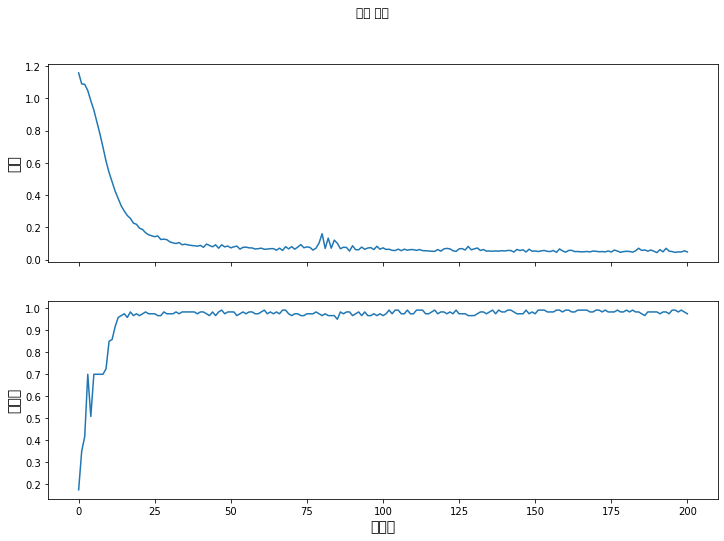

In [30]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('훈련 지표')

axes[0].set_ylabel("손실", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("정확도", fontsize=14)
axes[1].set_xlabel("에포크", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()